In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
import numpy as np
import math
import datetime

from netCDF4 import Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Input

In [9]:
from callbacks import AnnealingCallback

from models.AE import build_AE
from models.VAE import build_VAE
from models.VAE_DFC import build_DFC_VAE

# 1. Loading the data 

In [10]:
nc = Dataset('../Data/tohoku_2020.nc', 'r')
dim1 = int(np.array(nc.variables['lon']).shape[0])
dim2 = int(np.array(nc.variables['lat']).shape[0])
Z = np.flip(np.array(nc.variables['elevation']), axis=0) #otherwise the 'map' is upside down and mirrored

Plotting the full GEBCO may take time

In [11]:
#plt.figure(figsize=(10,5))
#plt.imshow(Z)

# 2. Pre-processing

#### Scale input into [0,1] where 0 is the global minimum and 1 global maximum. Necessary since the models were trained on the global data.

In [12]:
# min and max values from the global GEBCO 2019 version
Z_global_min = -10880.587890625
Z_global_max = 8613.15625


Z_min = Z_global_min
Z_max = Z_global_max + np.abs(Z_min)


Z = (Z + np.abs(Z_min)) / Z_max # is now in [0,1] of either local data domain or global

#### Break down into samples of size (x,y)

In [13]:
x, y = 96, 96

In [14]:
num_images = int(dim1*dim2 / (x*y))

cutoff_x = math.ceil(x * (dim1/x-int(dim1/x)))
cutoff_y = math.ceil(y * (dim2/y-int(dim2/y)))

number of images; amount of pixels lost on x-axis; y-axis

In [15]:
num_images, cutoff_x, cutoff_y

(17805, 66, 39)

#### Reshaping

In [16]:
data = np.zeros([num_images, y, x])
i=0
for r in range(0, Z.shape[0]-cutoff_y, y):
    for c in range(0, Z.shape[1]-cutoff_x, x):
        data[i, :, :] = Z[r:r+y, c:c+x]
        i = i + 1

#### Train-test split

In [17]:
test_size=0.05
X_training, X_test = train_test_split(data, test_size=test_size, random_state=7)

#### Data augmentation

In [18]:
nbr_rotations = 0

In [19]:
index = X_training.shape[0]

if nbr_rotations == 3:
    X_train = np.zeros([index*4, y, x])
elif nbr_rotations == 2:
    X_train = np.zeros([index*3, y, x])
elif nbr_rotations == 1:
    X_train = np.zeros([index*2, y, x])
else:
    X_train = np.zeros_like(X_training)

X_train[0:index, :, :] = X_training

if nbr_rotations > 0:
    for j in range(index):
        X_train[index*1 + j, :, :] = X_training[j, :, :].T
        if nbr_rotations == 3:
            X_train[index*2 + j, :, :] = np.flip(X_training[j, :, :])
            X_train[index*3 + j, :, :] = np.flip(X_training[j, :, :].T)
        elif nbr_rotations == 2:
            X_train[index*2 + j, :, :] = np.flip(X_training[j, :, :])

#### Create validation set

In [14]:
X_train, X_val = train_test_split(X_train, test_size=test_size, random_state=7)

In [15]:
#reshaping for keras model input
X_train = X_train.reshape(-1, y, x, 1)
X_val   = X_val.reshape(-1, y, x, 1)
X_test  = X_test.reshape(-1, y, x, 1)

In [16]:
del X_training

# 3. Build model 

In [17]:
inputs = Input(shape = (y, x, 1), name='encoder_inputs')

#### Model set-up

In [18]:
kernel_down = 4                 #kernel size for downsampling
kernel_up   = 3                 #kernel size for upsampling
filters = [64, 128, 128, 256]   #kernels used at each layer (decoding is the reverse of this)

#VAE specific:
latent_dim  = 100               #corresponds to the latent distribution's dimensionality

#DFC VAE specific:
selected_VGG_layer_weights=[1.0, 0.75, 0.5, 0.5]
selected_VGG_layers = ['block1_conv2', 'block2_conv2', 'block3_conv2', 'block4_conv2']

#### Choose between autoencoder (AE), variational autoencoder (VAE), deep feature consistent variational autoencoder (DFC VAE)

In [19]:
#model = build_AE(inputs, filters, kernel_down, kernel_up)
#model, encoder, decoder = build_VAE(inputs, filters, kernel_down, kernel_up, latent_dim)
model, encoder, decoder, lossModel = build_DFC_VAE(inputs, filters, kernel_down, kernel_up, latent_dim, selected_VGG_layer_weights, selected_VGG_layers)


try:
    encoded = keras.models.Model(inputs=inputs, outputs=model.get_layer('encoder').get_layer('encoded').output)
except:
    encoded = keras.models.Model(inputs=inputs, outputs=model.get_layer('encoded').output)

Model summary:

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_inputs (InputLayer)  (None, 96, 96, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 100), (None, 100) 1863308   
_________________________________________________________________
decoder (Model)              (None, 96, 96, 1)         1459189   
Total params: 3,322,497
Trainable params: 3,320,705
Non-trainable params: 1,792
_________________________________________________________________


# 4. Training 

#### Hyper-parameters

In [21]:
epochs = 50
batch_size = 128
learning_rate = 1e-6

optimizer = keras.optimizers.Adam(lr=learning_rate, clipnorm=1)

#### Callbacks

In [22]:
callback_list = []

Use exponential annealing for KL divergence loss (recommended)

In [23]:
weight = keras.backend.variable(0.0)
callback_list.append(AnnealingCallback(weight))

To save best model weights, specify/create path here

In [24]:
!mkdir model_weights/$(date +%Y%m%d)

filepath='model_weights/' + datetime.datetime.now().strftime('%Y%m%d') + '/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
save_weights_callback = keras.callbacks.ModelCheckpoint(filepath, save_best_only=True, 
                                                                  save_weights_only=True)
callback_list.append(save_weights_callback)

mkdir: model_weights/20200522: File exists


If you want to use Tensorboard:

In [25]:
#!mkdir logs
#!mkdir logs/fit

#log_dir='logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
#tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, write_grads=True, write_images=True)
#callback_list.append(tensorboard_callback)

Add other callbacks here:

In [26]:
#callback_list.append(keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, min_lr=1e-6))
#callback_list.append(keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1))

#### Compile & train

In [27]:
model.compile(optimizer = optimizer)

In [28]:
model.fit(X_train, batch_size=batch_size, epochs=epochs, verbose=1, #initial_epoch=,
          validation_data=(X_val, None), 
          callbacks=callback_list
         )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 16068 samples, validate on 846 samples
Epoch 1/50


AbortedError: Operation received an exception:Status: 5, message: could not create a view primitive descriptor, in file tensorflow/core/kernels/mkl_slice_op.cc:433
	 [[{{node training/Adam/gradients/concatenate_2/concat_grad/Slice_1}}]]

In [64]:
#model.load_weights('pre-trained_weights/AE.hd5')
#model.load_weights('pre-trained_weights/VAE.hdf5')
model.load_weights('pre-trained_weights/VAE_DFC.hdf5')

#### Plot train & val loss

In [ ]:
model_train = model.history
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']

plt.figure()
plt.plot(range(epochs), loss, 'bo', label='Training loss')
plt.plot(range(epochs), val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

# 5. Model outputs 

normalize reconstruction heat-map color coding?

In [70]:
normalize = False

### Performance on test set

In [66]:
pred = model.predict(X_test)
encoded_states = np.mean(encoded.predict(X_test), axis=3, keepdims=True)

x_encoded = encoded_states.shape[1]
y_encoded = encoded_states.shape[2]

L2 error on test set

In [67]:
error_test = np.linalg.norm(X_test - pred, axis=(1,2))
max_test_error = np.argmax(error_test)

print("Test set L2 error: " + str(np.linalg.norm(error_test)) + 
      ", maximum per sample error: " + str(error_test[max_test_error]))

Test set L2 error: 28.932577152759805, maximum per sample error: [9.39808547]


Plot model reconstructions on test set samples

Test Images (96x96)


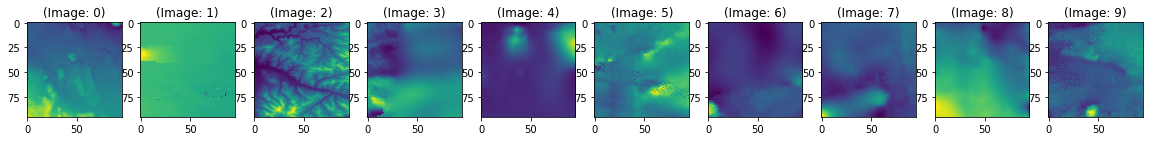

Reconstruction of Test Images (96x96)


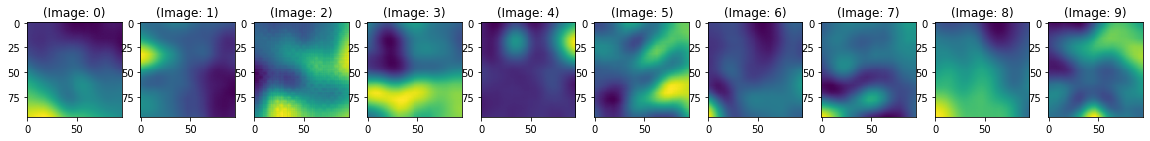

Latent Representation of Test Images (6x6)


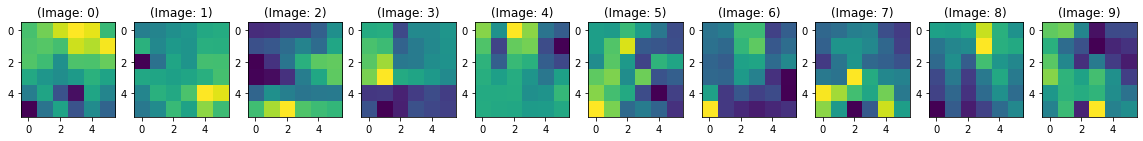

In [71]:
vmin = np.zeros(10)
vmax = np.zeros(10)

plt.figure(figsize=(20, 4))
print("Test Images (" + str(y) + "x" + str(x) + ")")
for i in range(10):
    plt.subplot(2, 10, i+1)
    vmin[i] = np.min(X_test[i, ..., 0])
    vmax[i] = np.max(X_test[i, ..., 0])
    norm = plt.Normalize(vmin=vmin[i], vmax=vmax[i]) if normalize==True else None
    plt.imshow(X_test[i, ..., 0], norm=norm)
    plt.title("(Image: " + str(i) + ")")
plt.show()

plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images (" + str(y) + "x" + str(x) + ")")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(pred[i, ..., 0], norm=norm)
    plt.title("(Image: " + str(i) + ")")
plt.show()

plt.figure(figsize=(20, 4))
print("Latent Representation of Test Images (" + str(y_encoded) + "x" + str(x_encoded) + ")")
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.imshow(encoded_states[i, ..., 0])
    plt.title("(Image: " + str(i) + ")")
plt.show()

Plot worst reconstruction

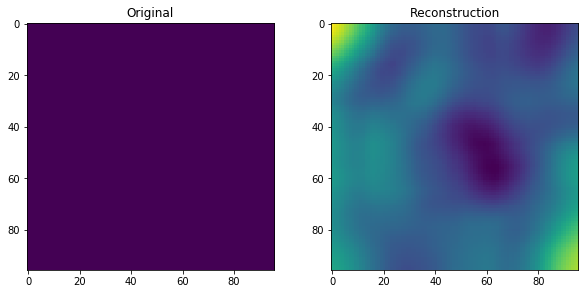

In [72]:
vmin = np.min(X_test[max_test_error, :, :, 0])
vmax = np.max(X_test[max_test_error, :, :, 0])

norm = plt.Normalize(vmin=vmin, vmax=vmax) if normalize==True else None

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title("Original")
plt.imshow(X_test[max_test_error, :, :, 0], norm=norm)
plt.subplot(2,2,2)
plt.title("Reconstruction")
plt.imshow(pred[max_test_error, :, :, 0], norm=norm)

### Performance on the entire dataset

In [49]:
#reconstruct input data using the model
data_reconstructed = model.predict(data.reshape(-1, y, x, 1)).reshape(-1, y, x)
data_encoded = np.mean(encoded.predict(data.reshape(-1, y, x, 1)), axis=3, keepdims=True)

In [50]:
error_total = np.linalg.norm(data - data_reconstructed, axis=(1,2))
max_total_error = np.argmax(error_total)

print("Total L2 error: " + str(np.linalg.norm(error_total)) + 
      ", maximum per sample error: " + str(error_total[max_total_error]))

Total L2 error: 155.0464219763884, maximum per sample error: 10.667635917663574


Plot worst reconstruction

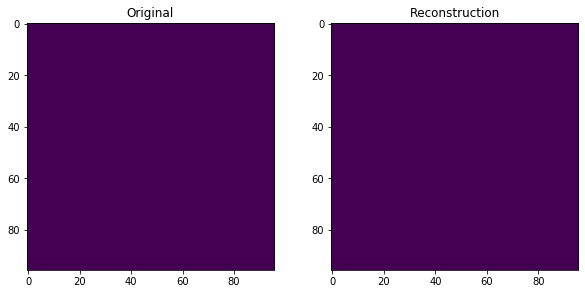

In [51]:
vmin = np.min(data[max_total_error, :, :])
vmax = np.max(data[max_total_error, :, :])

norm = plt.Normalize(vmin=vmin, vmax=vmax) if normalize==True else None

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title("Original")
plt.imshow(data[max_total_error, :, :], norm=norm)
plt.subplot(2,2,2)
plt.title("Reconstruction")
plt.imshow(data_reconstructed[max_total_error, :, :], norm=norm)

### plots

In [52]:
x_encoded = data_encoded.shape[1]
y_encoded = data_encoded.shape[2]

In [53]:
Z_reconstructed = Z.copy()
Z_encoded = np.zeros([int(dim2/y)*y_encoded, int(dim1/x)*x_encoded])

i=0
for r in range(0, Z.shape[0]-cutoff_y, y):
    for c in range(0, Z.shape[1]-cutoff_x, x):
        Z_reconstructed[r:r+y, c:c+x] = data_reconstructed[i, ..., 0]
        i = i + 1

i=0
for r in range(0, Z_encoded.shape[0], y_encoded):
    for c in range(0, Z_encoded.shape[1], x_encoded):
        Z_encoded[r:r+y_encoded, c:c+x_encoded] = data_encoded[i, ..., 0]
        i = i + 1

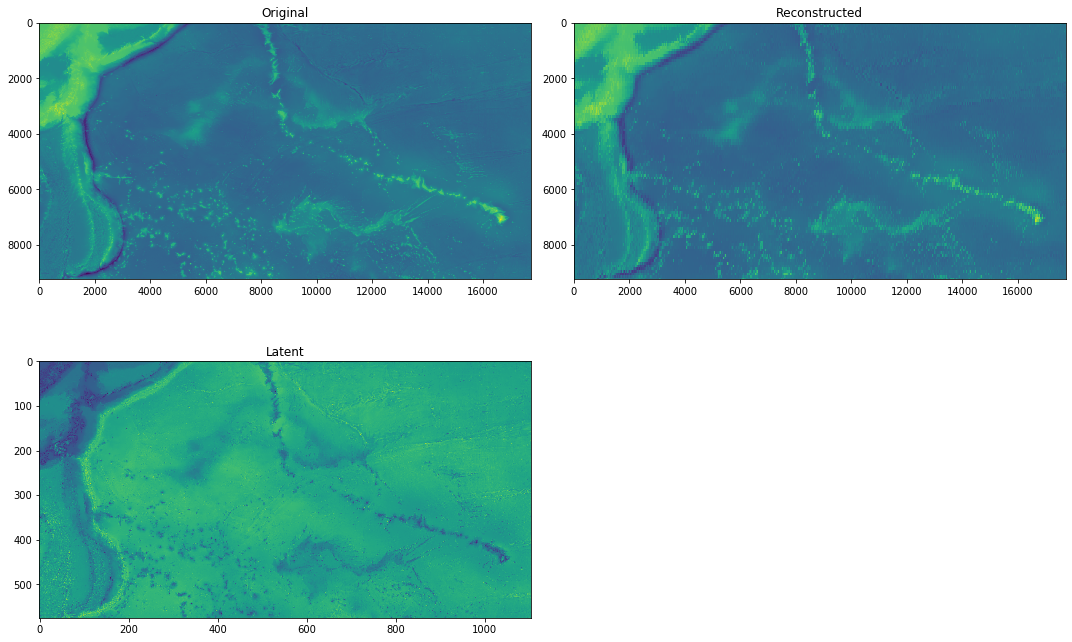

In [54]:
vmin = np.min(Z)
vmax = np.max(Z)

norm = plt.Normalize(vmin=vmin, vmax=vmax) if normalize==True else None

plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title("Original")
plt.imshow(Z, norm=norm)
plt.subplot(2,2,2)
plt.title("Reconstructed")
plt.imshow(Z_reconstructed, norm=norm)
plt.subplot(2,2,3)
plt.title("Latent")
plt.imshow(Z_encoded)

plt.tight_layout()
plt.subplots_adjust(hspace=-0.53)

# 6. Write to output 

scale back to match original domain

In [40]:
#Z_reconstructed = Z_reconstructed * Z_max - np.abs(Z_min)

create output dataset

In [57]:
#!cp ../Data/tohoku_2020.nc ../Data/tohoku_2020_reconstruction.nc

In [58]:
#out = Dataset('../Data/tohoku_2020_reconstruction.nc', 'r+')
#temp  = np.flip(out.variables['elevation'][:], axis=0)

Original and reconstruction min/max altitudes

In [59]:
#print("Original max altitude: " + str(np.max(temp)) + " reconstructed: " + str(np.max(Z_reconstructed)))
#print("Original min altitude: " + str(np.min(temp)) + " reconstructed: " + str(np.min(Z_reconstructed)))

Original max altitude: 4163 reconstructed: 4195.951845395146
Original min altitude: -10952 reconstructed: -8935.0


Use model output only for actual bathymetry values, i.e. below mean sea level

In [60]:
#temp[temp<0] = Z_reconstructed[temp<0]

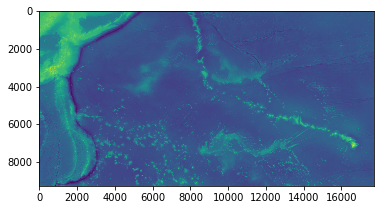

In [61]:
#plt.imshow(temp)

In [62]:
#out.variables['elevation'][:] = np.flip(temp, axis=0)
#out.close()